In [ ]:
!pip -q install rasterio matplotlib numpy

     |████████████████████████████████| 18.3MB 162kB/s 


# Libraries and data loading

In [ ]:
import rasterio as rio
from matplotlib import pyplot as plt
import numpy
import os
import pandas as pd
from sklearn.cluster import KMeans

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# enter your google drive path where images are located
bf_folder ='drive/My Drive/kenya_aoi_png/kenya_before_png/'
#af_folder ='drive/My Drive/kenya_aoi_png/kenya_after_png/'

In [ ]:
# Save filenames to an array
bf_data = []

for filename in os.listdir(bf_folder):
    if filename.endswith("png"): 
        fname = 'drive/My Drive/kenya_aoi_png/kenya_before_png/' + filename
        bf_data.append(fname)

bf_data.sort()
print(bf_data[:5])

['drive/My Drive/kenya_aoi_png/kenya_before_png/kenya_aoi_before (100).png', 'drive/My Drive/kenya_aoi_png/kenya_before_png/kenya_aoi_before (103).png', 'drive/My Drive/kenya_aoi_png/kenya_before_png/kenya_aoi_before (104).png', 'drive/My Drive/kenya_aoi_png/kenya_before_png/kenya_aoi_before (106).png', 'drive/My Drive/kenya_aoi_png/kenya_before_png/kenya_aoi_before (107).png']


In [ ]:
print("Length of bf data=", len(bf_data))

Length of bf data= 261


# Import VGG model in Keras

In [ ]:
import cv2
import os
import numpy as np
from keras.models import load_model, Model
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

def get_model(layer='fc2'):
    """Keras Model of the VGG16 network, with the output layer set to `layer`.
    The default layer is the second-to-last fully connected layer 'fc2' of
    shape (4096,).
    Parameters
    ----------
    layer : str
        which layer to extract (must be of shape (None, X)), e.g. 'fc2', 'fc1'
        or 'flatten'
    """
    # base_model.summary():
    #     ....
    #     block5_conv4 (Conv2D)        (None, 15, 15, 512)       2359808
    #     _________________________________________________________________
    #     block5_pool (MaxPooling2D)   (None, 7, 7, 512)         0
    #     _________________________________________________________________
    #     flatten (Flatten)            (None, 25088)             0
    #     _________________________________________________________________
    #     fc1 (Dense)                  (None, 4096)              102764544
    #     _________________________________________________________________
    #     fc2 (Dense)                  (None, 4096)              16781312
    #     _________________________________________________________________
    #     predictions (Dense)          (None, 1000)              4097000
    #
    base_model = VGG16(weights='imagenet', include_top=True)
    model = Model(inputs=base_model.input,
                outputs=base_model.get_layer(layer).output)
    return model


# Helper functions for feature extraction

In [ ]:
def get_files(path_to_files, size):
    fn_imgs = []
    files = [file for file in os.listdir(path_to_files)]
    for file in files:
        img = cv2.resize(cv2.imread(path_to_files+file), size)
        fn_imgs.append([file, img])
    return dict(fn_imgs)

In [ ]:
def feature_vector(img_arr, model):
    if img_arr.shape[2] == 1:
      img_arr = img_arr.repeat(3, axis=2)

    # (1, 224, 224, 3)
    arr4d = np.expand_dims(img_arr, axis=0)  
    arr4d_pp = preprocess_input(arr4d)
    return model.predict(arr4d_pp)[0,:]

In [ ]:
def feature_vectors(imgs_dict, model):
    f_vect = {}
    for fn, img in imgs_dict.items():
      f_vect[fn] = feature_vector(img, model)
    return f_vect 

# Find feature vectors for our data (before-attack images)

In [ ]:
imgs_dict = get_files(path_to_files = 'drive/My Drive/kenya_aoi_png/kenya_before_png/',size = (224, 224))

# Create Keras NN model.
model = get_model()

# Feed images through the model and extract feature vectors.
img_feature_vector = feature_vectors(imgs_dict, model)

553467904/553467096 [==============================] - 34s 0us/step


# Use elbow method to find optimal value of k 

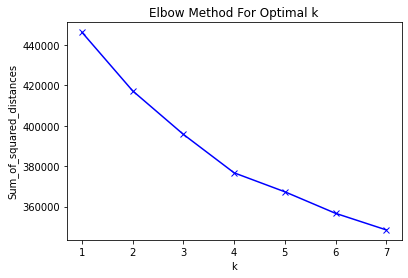

In [ ]:
images = list(img_feature_vector.values())
fns = list(img_feature_vector.keys())
sum_of_squared_distances = []
K = range(1, 8)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(images)
    sum_of_squared_distances.append(km.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#Note: It is possible to manually set this value of k to number of desired clusters

# Apply k-means to the feature vectors obtained from VGG

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(images)
y_kmeans = kmeans.predict(images)
file_names = list(imgs_dict.keys())

# Save images grouped by cluster value

In [ ]:
n_clusters = 4
cluster_path = 'drive/My Drive/Clusters/'
path_to_files = 'drive/My Drive/kenya_aoi_png/kenya_before_png/'

for c in range(0,n_clusters):
    if not os.path.exists(cluster_path+'cluster_'+str(c)):
        os.mkdir(cluster_path+'cluster_'+str(c))
    
for fn, cluster in zip(file_names, y_kmeans):
    image = cv2.imread(path_to_files+fn)
    cv2.imwrite(cluster_path+'cluster_'+str(cluster)+'/'+fn, image)

# Visualisations

Number of images in this cluster 0 = 70


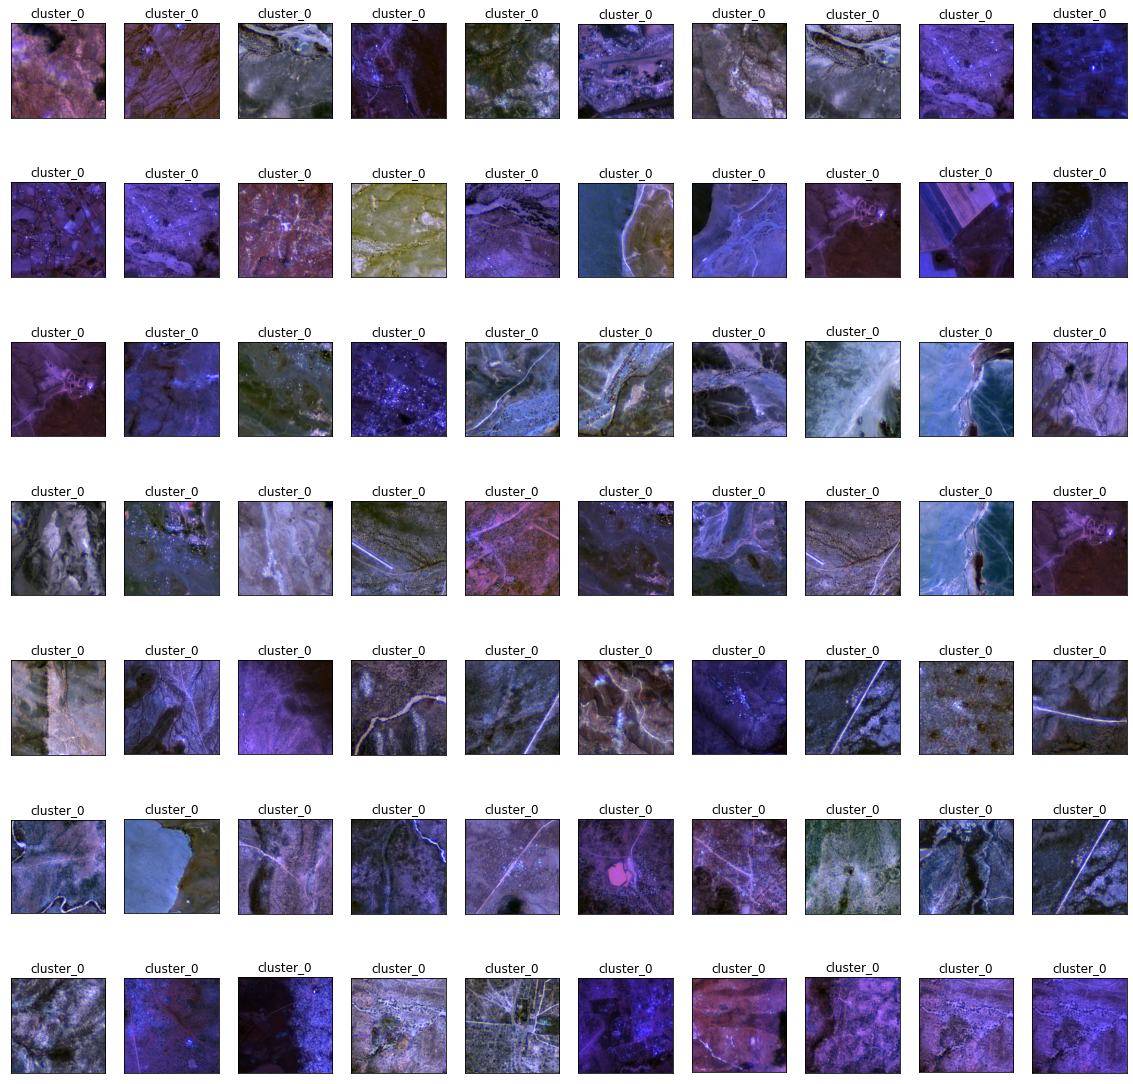

In [ ]:
fig = plt.figure(figsize=(20,20))

cluster_path = 'drive/My Drive/Clusters/cluster_0/'
images = [file for file in os.listdir(cluster_path)]

print("Number of images in this cluster 0 =", len(images))

for cnt, data in enumerate(images):
#     print(data)
    y = fig.add_subplot(7, 10, cnt+1)
    img = mpimg.imread(cluster_path+data)
    y.imshow(img)
    plt.title('cluster_0')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

Number of images in this cluster 1 = 61


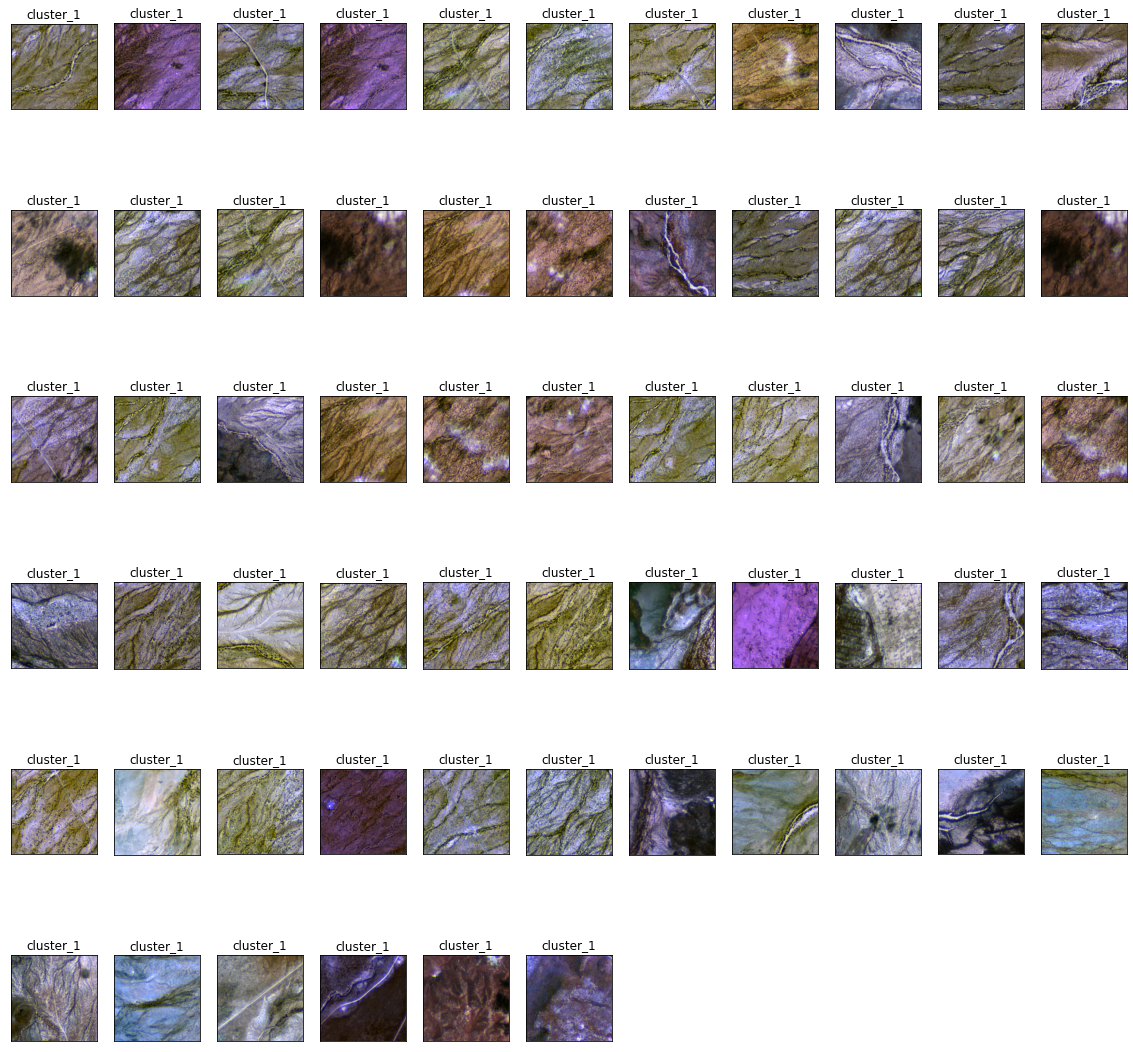

In [ ]:
fig = plt.figure(figsize=(20,20))

cluster_path = 'drive/My Drive/Clusters/cluster_1/'
images = [file for file in os.listdir(cluster_path)]

print("Number of images in this cluster 1 =", len(images))

for cnt, data in enumerate(images):
#     print(data)
    y = fig.add_subplot(6, 11, cnt+1)
    img = mpimg.imread(cluster_path+data)
    y.imshow(img)
    plt.title('cluster_1')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

Number of images in this cluster 2 = 59


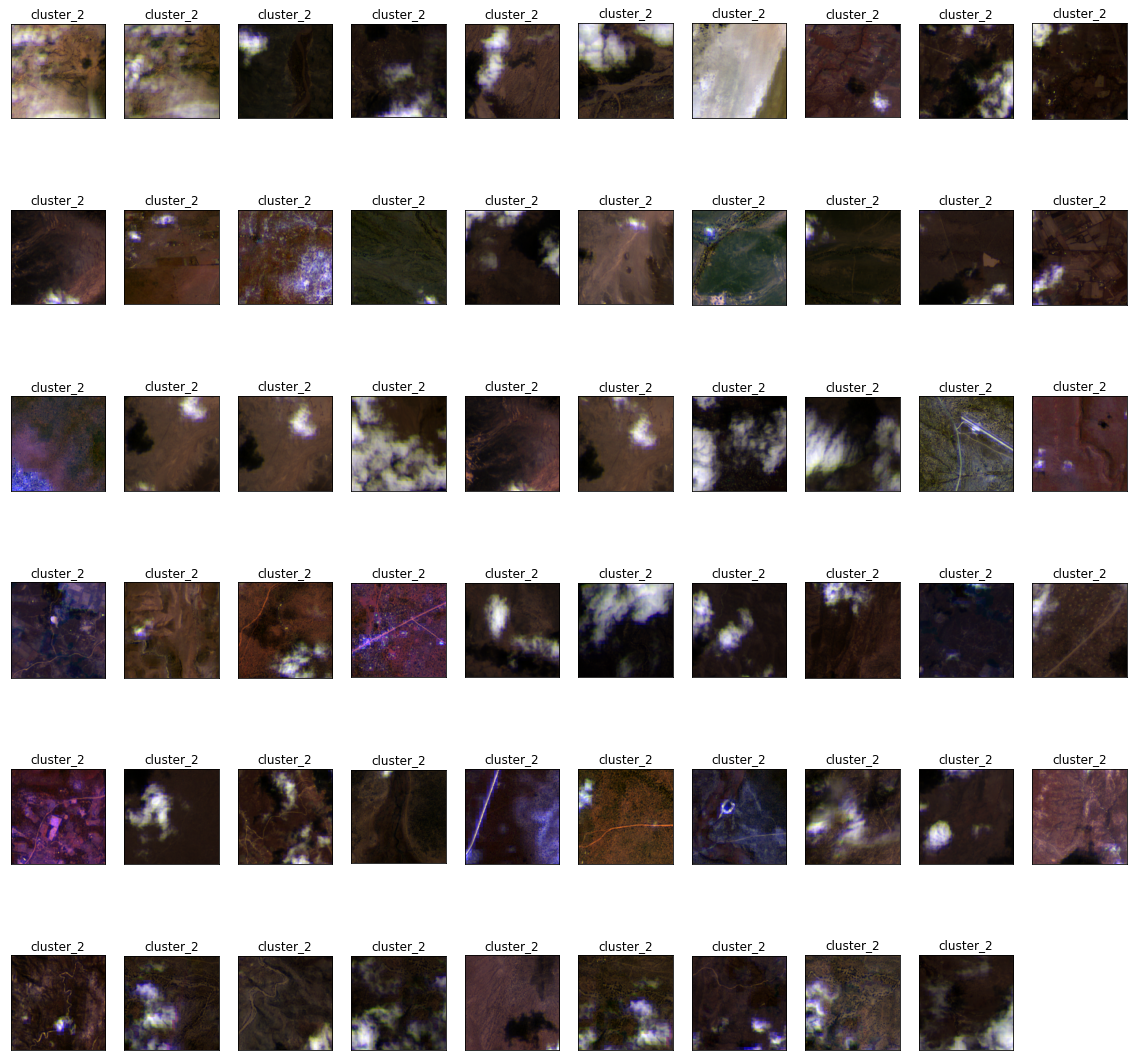

In [ ]:
fig = plt.figure(figsize=(20,20))

cluster_path = 'drive/My Drive/Clusters/cluster_2/'
images = [file for file in os.listdir(cluster_path)]

print("Number of images in this cluster 2 =", len(images))

for cnt, data in enumerate(images):
#     print(data)
    y = fig.add_subplot(6,10, cnt+1)
    img = mpimg.imread(cluster_path+data)
    y.imshow(img)
    plt.title('cluster_2')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

Number of images in this cluster 3 = 71


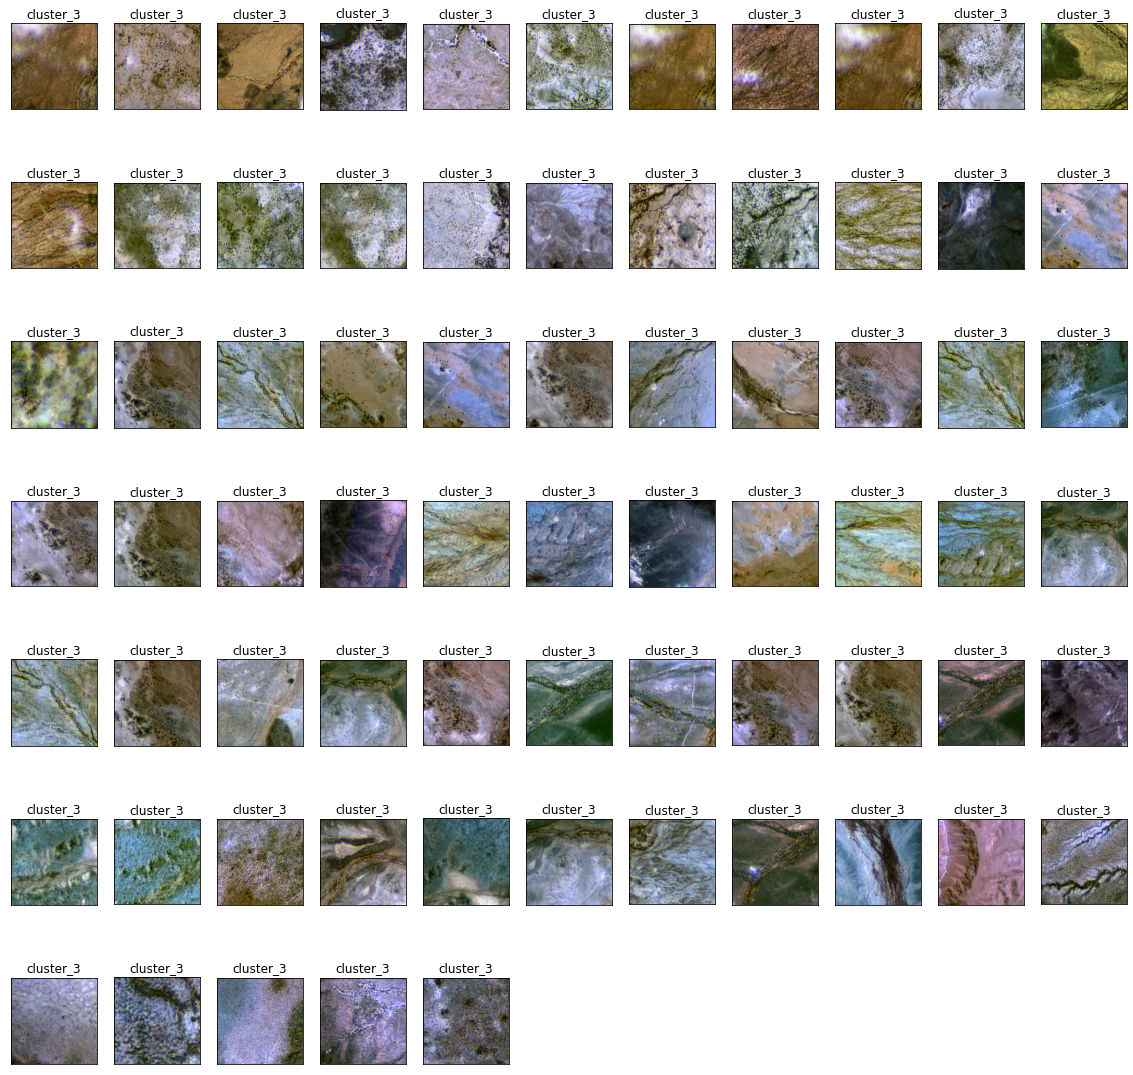

In [ ]:
fig = plt.figure(figsize=(20, 20))

cluster_path = 'drive/My Drive/Clusters/cluster_3/'
images = [file for file in os.listdir(cluster_path)]

print("Number of images in this cluster 3 =", len(images))

for cnt, data in enumerate(images):
#     print(data)
    y = fig.add_subplot(7, 11, cnt+1)
    img = mpimg.imread(cluster_path+data)
    y.imshow(img)
    plt.title('cluster_3')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

# Acknowledgement

The original Github repository from where this code has been taken https://github.com/naikshubham/Image-Clustering-Using-Convnets-Transfer-Learning-and-K-Means-/blob/master/image_clustering.ipynb